### Lib import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log
from scipy.special import expi
from sklearn import metrics

### Function declare

In [2]:
def plot_data(data):
    
    pass

### Parameters assignment

In [3]:
#Dimentions
# q = bbl/d; P = psi; m = cp; k = mD; h = ft; phi = %; ct = psi^(-1); t = hours

#Parameters
q1 = 500           #bbl/d
q2 = 400           #bbl/d  -  second well
P = 4350           #psi
m = 1              #cp 
k = 100            #mD 
ct = 6*10**(-6)    #1/psi
r = 0.178*3.28084  # meter to ft (7 inch radius)
h = 100            #ft
s = 4
phi = 0.25
gamma = 1.781

q_si = q1*1.8401*10**(-6)
m_si = m*10**(-3)
k_si = k*10**(-15)
h_si = h*0.3048


# Distance to fault
L = 200*3.28084    #ft (200 m)
Ld = L/r

### Td(2Ld)^2 > 0.25 condition (End of transition: Td(2Ld)^2 = 25)

In [4]:
#Time to fault
t2 = phi*m*ct*L**2/k/(0.01217)**2
print(str("{:0.2f}".format(t2/24))+ ' days to fault')

1.82 days to fault


In [5]:
x = np.linspace(0.1,10**4,10**5)
for i in x:
    td = 0.00026367*k*i/phi/m/ct/(r**2)
    n = td/(2*Ld)**2
    if n > 0.25:
        print('Transition starts after '+str("{:0.2f}".format(i/24))+' days')
        t2_transition = i
        break
for i in x:
    td = 0.00026367*k*i/phi/m/ct/(r**2)
    n = td/(2*Ld)**2
    if n > 25:
        print('Transition ends after '+str("{:0.2f}".format(i/24))+' days')
        break

Transition starts after 1.02 days
Transition ends after 102.06 days


In [6]:
t2_transition

24.5

In [7]:
# Radial flow
t = np.linspace(0.0001,48,200)  # hours
p = P-162.6*q1*m/k/h*(np.log10(k*t/phi/m/ct/r**2)-3.23+0.87*s)    # flow rate in reservoir terms
p = np.concatenate([[P],p])

#Radial flow via ExpInt function
dP_skin = 141.2*q1*m/k/h*s
dP_skin_si = (q_si*m_si/k_si/h_si/(2*np.pi))*s*0.000145038
p_expi = P+70.6*q1*m/k/h*expi(-948*phi*m*ct*r**2/k/t)-dP_skin
p_expi = np.concatenate([[P],p_expi])


# Single fault
p2_1 = []
p2_2 = []
for dt in t:
    if dt < t2_transition:
        p2_1.append(P-162.6*q1*m/k/h*(np.log10(k*dt/phi/m/ct/r**2)-3.23+0.87*s))
    else:
        p2_2.append(P-162.6*q1*m/k/h*(np.log10(k*dt/phi/m/ct/r**2)+
                                        np.log10(k*dt/phi/m/ct/(2*L)**2)-2*3.23+0.87*s))
#adjusting second array & andding Pi
p2_1 = np.array(p2_1)
p2_2 = np.array(p2_2)
dP = p2_2[0]-p2_1[-1]
p2 = np.append(p2_1, p2_2-dP)
p2 = np.concatenate([[P],p2])


# 90degree intercepting faults
p3_1 = []
p3_2 = []
for dt in t:
    if dt < t2_transition:
        p3_1.append(P-162.6*q1*m/k/h*(np.log10(k*dt/phi/m/ct/r**2)-3.23+0.87*s))
    else:
        p3_2.append(P-162.6*q1*m/k/h*(np.log10(k*dt/phi/m/ct/r**2)+
                                        3*np.log10(k*dt/phi/m/ct/(2*L)**2)-4*3.23+0.87*s))
#adjusting second array & adding 0
p3_1 = np.array(p3_1)
p3_2 = np.array(p3_2)
dP_2 = p3_2[0]-p3_1[-1]
p3 = np.append(p3_1, p3_2-dP_2)
p3 = np.concatenate([[P],p3])


# + Injection well
p4_1 = []
p4_2 = []
for dt in t:
    if dt < t2:
        p4_1.append(P-q1*m/4/np.pi/k/h*(np.log(k*dt/phi/m/ct/r**2)+0.80908+2*s))
    else:
        p4_2.append(P-q1*m/4/np.pi/k/h*(np.log(k*dt/phi/m/ct/r**2)+0.80908+2*s)-
                    (q2-q1)*m/4/np.pi/k/h*(np.log(k*(dt-t2)/phi/m/ct/r**2)+0.80908+2*s))
    p4 = np.append(p4_1,p4_2)
p4_bar = p3/101325


#Adding 0 time to time-array
t = np.concatenate([[0],t])

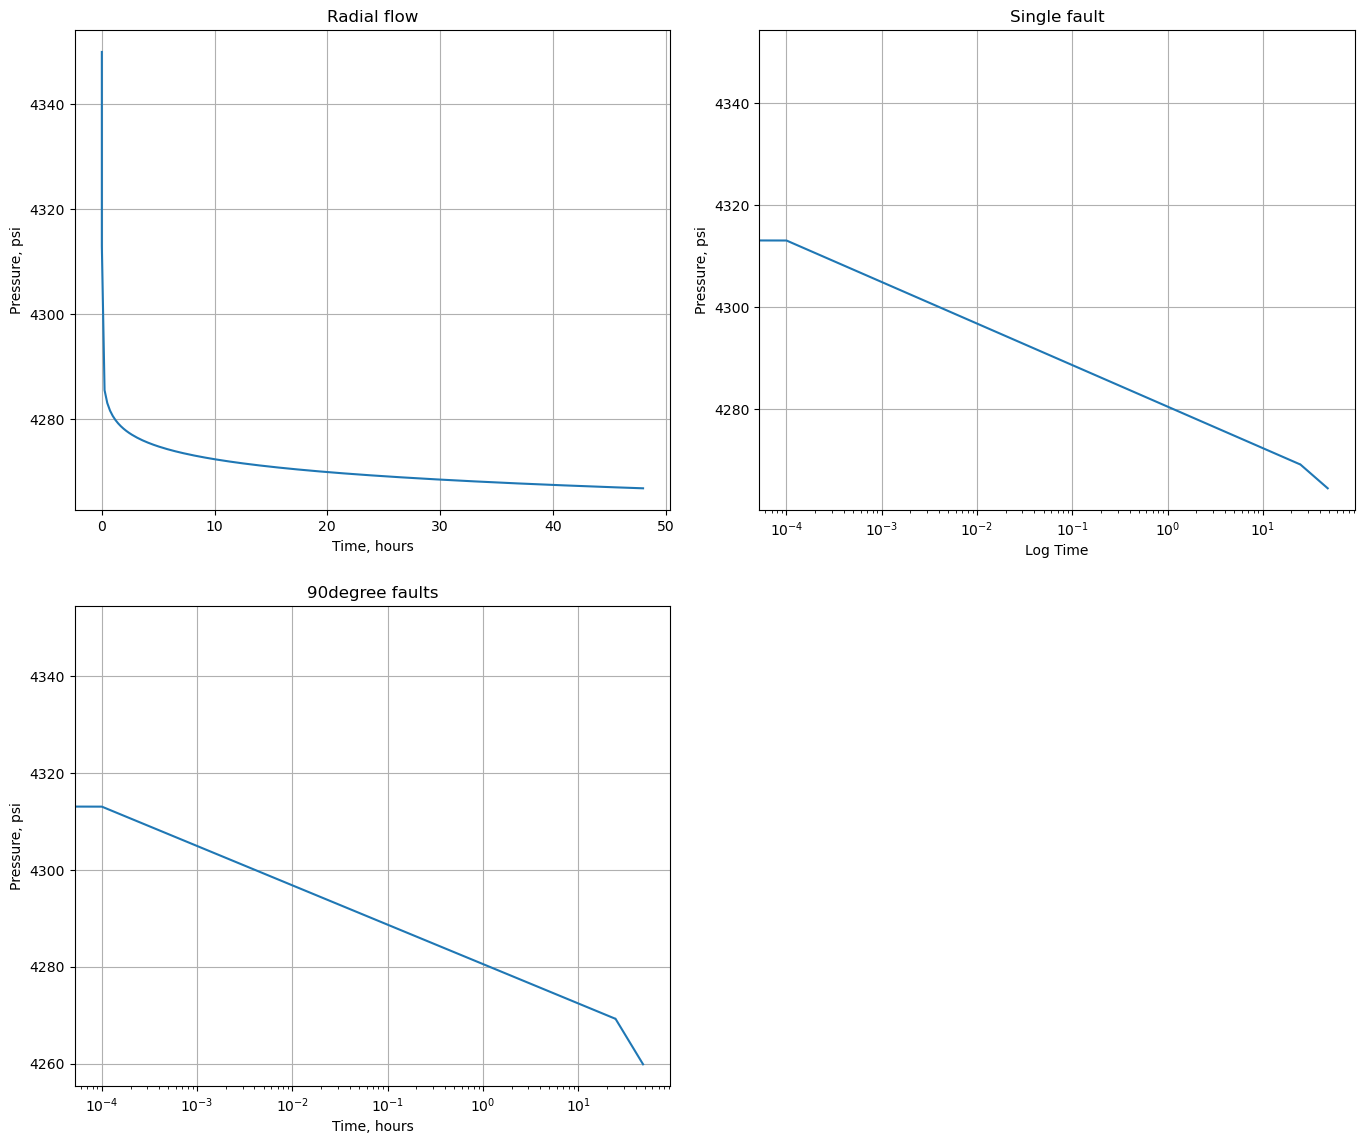

In [8]:
#fig, ax = plt.subplots(1,1, figsize=)
plt.subplot(221)
plt.plot(t,p)
plt.title('Radial flow')
#plt.xscale('log')
plt.xlabel('Time, hours')
plt.ylabel('Pressure, psi')
plt.grid()

plt.subplot(222)
plt.plot(t,p2)
plt.title('Single fault')
plt.xscale('log')
plt.xlabel('Log Time')
plt.ylabel('Pressure, psi')
plt.grid()

plt.subplot(223)
plt.plot(t,p3)
plt.title('90degree faults')
plt.xscale('log')
plt.xlabel('Time, hours')
plt.ylabel('Pressure, psi')
plt.grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=2.2, wspace=0.15, hspace=0.2)
plt.show()

### Ln - Ei pressure difference

Pressure difference between Ln and Ei is  -8.59 psi


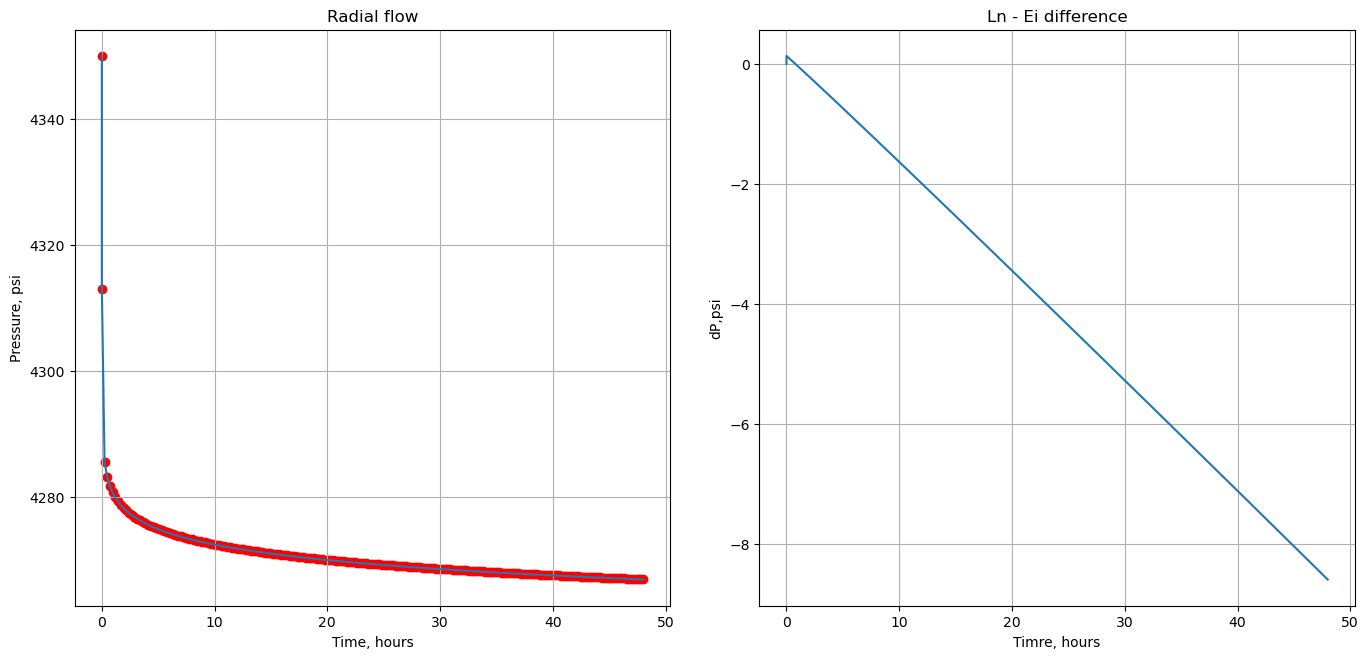

In [9]:
dif_P = p-p_expi
difference_P = np.zeros(len(p))
for n in enumerate(dif_P):
    if n[0] == 0:
        difference_P[n[0]] = n[1]
    else:
        difference_P[n[0]] = difference_P[n[0]-1] + n[1]
print('Pressure difference between Ln and Ei is  ' + str("{:0.2f}".format(difference_P[-1])) + ' psi')

plt.subplot(121)
plt.plot(t,p)
plt.scatter(t,p_expi, c='red')
plt.title('Radial flow')
#plt.xscale('log')
plt.xlabel('Time, hours')
plt.ylabel('Pressure, psi')
plt.grid()

plt.subplot(122)
plt.plot(t,difference_P)
plt.title('Ln - Ei difference')
plt.xlabel('Timre, hours')
plt.ylabel('dP,psi')
plt.grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1.2, wspace=0.15, hspace=0.2)
plt.show()